<a href="https://colab.research.google.com/github/dardeshna/frc-stuffs/blob/master/linalg/signal_recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal Recovery

In signal processing a common task is to extract the underlying signal from a noisy input. In this notebook we will explore how this can be done using a least squares approach.

In [1]:
# setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)
%config InlineBackend.figure_formats = ['svg']
plt.style.use('default')

## Generating a noisy signal

First we need to generate a test signal for us to denoise. To keep things simple we will stick with a signal that is composed of two sinusoids with different frequencies ($f$), amplitude ($A$) and phase ($\phi$).

\begin{gather*}
s(t)=A_1\cos(2\pi f_1 t + \phi_1)+A_2\cos(2\pi f_2 t + \phi_2)
\end{gather*}

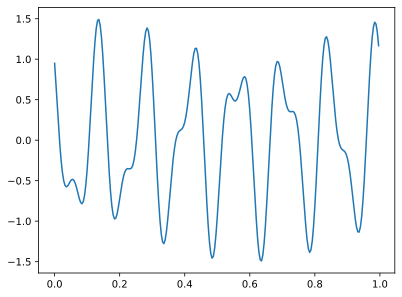

In [2]:
# length of signal and number of samples
T = 1 # seconds
N = 250 # samples

# array of timestamps
t = np.arange(N)/(N/T)

# properties for each sinusoid
f_1 = 7 # Hz
f_2 = 13 # Hz
amplitude_1 = 1
amplitude_2 = 0.5
phase_1 = 25 # deg
phase_2 = 85 # deg

# calculate the signal by summing the two sinusoids
signal = amplitude_1*np.cos(2*np.pi*f_1*t + np.radians(phase_1)) + amplitude_2*np.cos(2*np.pi*f_2*t + np.radians(phase_2))

# plot the signal
plt.plot(t, signal)
plt.show()

Next we will add some noise to our signal. We can do this using `np.random.normal()` which generates random data from a normal distribution $\mathcal{N}(0, \sigma)$. Here, $\sigma$ is the standard deviation of the random data, which measures how spread out it is. Roughly 68% of the data will be smaller in magnitude than $\sigma$ and we can set it using the `scale` parameter.

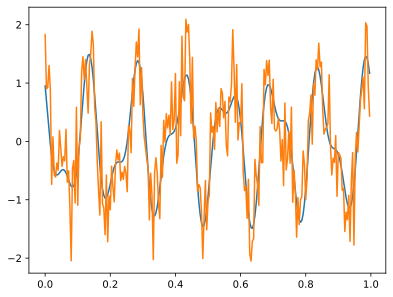

In [3]:
# add random noise to signal
noisy_signal = signal + np.random.normal(size=signal.shape, scale=0.5)

# plot noisy signal over original signal
plt.plot(t, signal)
plt.plot(t, noisy_signal)
plt.show()

## Recovering the original signal

Now that we have our noisy signal, how do we recover it? We will make the assumption that our signal is made up of some combination of sinusoids. This may seem arbitrary, but it turns out every signal can replicated by adding enough sinusoids of different frequencies together.

First, we can use the noisy signal timestamps to generate sinusoids $\cos(2\pi f_i t)$ and $\sin(2\pi f_i t)$ for a range of frequencies. We generate both a cosine and sine wave because we don't know the phase of $f_i$ present in the original signal. The cosine wave leads the sine wave by 90°, so we can add different amounts of these two sinusoids to generate a new sinusoid with frequency $f_i$ and arbitrary phase.

Once we've generated sinusoids for each frequency we can set up a system of equations to solve for the relative contribution of each sinusoid.

\begin{gather*}
\mathbf{Ax} =
\begin{bmatrix}
1 & \cos(2\pi f_0 t_0) & \sin(2\pi f_0 t_0) & \dots & \cos(2\pi f_{n-1} t_0) & \cos(2\pi f_{n-1} t_0) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \cos(2\pi f_0 t_{m-1}) & \sin(2\pi f_0 t_{m-1}) & \dots & \cos(2\pi f_{n-1} t_{m-1}) & \cos(2\pi f_{n-1} t_{m-1}) \\
\end{bmatrix}
\begin{bmatrix}
X \\ C_0 \\ S_0 \\ \vdots \\ C_{n-1} \\ S_{n-1} \\
\end{bmatrix}
= \begin{bmatrix} s(t_0) \\ \vdots \\ s(t_{m-1}) \end{bmatrix}
= \mathbf{b}
\end{gather*}

Note: We add a column of ones at the beginning to capture any DC component the original signal might have. In other words, the the signal might be centered around a non-zero value. This will get picked up by this first column and the corresponding variable $X$.

Given $m$ timestamps, we will select $n$ frequencies where $2n+1<m$. This means that there are more unknowns than equations and $\mathbf{A}$ is a tall matrix. While there is no exact solution for $\mathbf{x}$, we can use `np.linalg.lstsq(A, b)` to solve for an $\mathbf{x}$ that minimizes the error $\| \mathbf{Ax}-\mathbf{b} \|$.

In [4]:
# construct a range of frequencies
f_min = 1
f_max = 20
frequencies = np.arange(f_min, f_max)

# initialize matrix and fill first column wih ones
A = np.zeros((len(noisy_signal), 1 + 2*len(frequencies)))
A[:, 0] = 1

# fill each column with the corresponding sinusoid
for i, f in enumerate(frequencies):
    A[:, 1+2*i] = np.cos(2*np.pi*f*t)
    A[:, 1+2*i+1] = np.sin(2*np.pi*f*t)

# solve for the relative contributions of each column
x = np.linalg.lstsq(A, noisy_signal, rcond=None)[0]

Now we have the relative contributions of sine ($S_i$) and cosine ($C_i$) for each $f_i$. However, to make these values more interpretable we can transform each pair $(S_i, C_i)$ to amplitude and phase $(A_i, \phi_i)$ of a shifted cosine. The formulas are as follows:

\begin{gather*}
A_i=\sqrt{S_i^2+C_i^2} \\
\phi_i = \mathrm{arctan2}(-S_i, C_i)
\end{gather*}

In [5]:
# initialize amplitude and phase arrays
amplitude = np.zeros(frequencies.shape)
phase = np.zeros(frequencies.shape)

# calculate amplitude and phase for each frequency using formulas from above
for i, f in enumerate(frequencies):
    C = x[1+2*i]
    S = x[1+2*i+1]
    amplitude[i] = np.sqrt(C**2+S**2)
    phase[i] = np.degrees(np.arctan2(-S, C))

Next we can plot the amplitude and phase for each frequency and see if the ampliude and phase of the frequencies from the original signal match the recovered values.

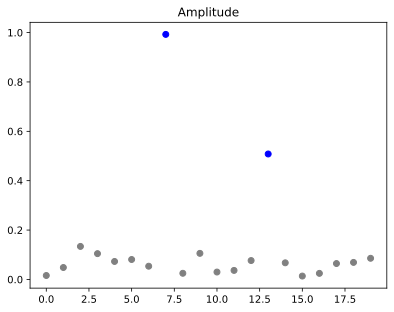

In [6]:
plt.plot(0,np.abs(x[0]),'o',color='gray') # dc component

# iterate through frequencies and highlight frequencies in original signal
for i, f in enumerate(frequencies):
    plt.plot(f, amplitude[i], 'o', color='blue' if f in (f_1,f_2) else 'gray')
plt.title("Amplitude")
plt.show()

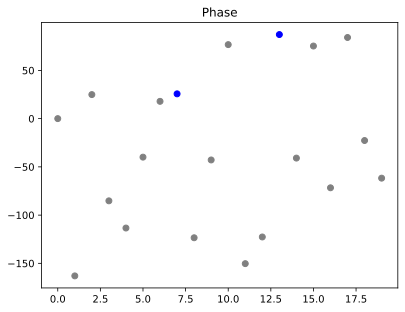

In [7]:
plt.plot(0,x[0],'o',color='gray') # dc component

# iterate through frequencies and highlight frequencies in original signal
for i, f in enumerate(frequencies):
    plt.plot(f, phase[i], 'o', color='blue' if f in (f_1,f_2) else 'gray')
plt.title("Phase")
plt.show()

Finally we can construct our recovered signal! We will only include the frequency components with an amplitude above a certain threshold.

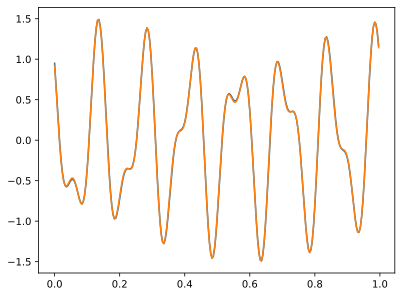

In [8]:
# amplitude threshold to include frequency component
amplitude_threshold = 0.3

# initialize recovered signal
recovered_signal = np.zeros_like(noisy_signal)

# add cos(2*pi*f*t + phi) to the recovered signal for each frequency with amplitude above the threshold
for i, f in enumerate(frequencies):
    if amplitude[i] > amplitude_threshold:
        recovered_signal += amplitude[i] * np.cos(2*np.pi*f*t + np.radians(phase[i]))

# plot original and recovered signal
plt.plot(t, signal)
plt.plot(t, recovered_signal)
plt.show()

## Bonus: Relationship to DFT

It turns out that the amplitude and phase for each frequency found by least squares are the same amplitude and phase given by the Discrete Fourier Transform (DFT). The DFT is a method to decompose any signal into its spectral components, which is exactly what we are doing here. For more information on the DFT, which is widely used in engineering, check out the wikipedia page:

https://en.wikipedia.org/wiki/Discrete_Fourier_transform

In [9]:
# compute the fft (returns a complex number for each frequency)
# forward normalization divides the result by 1/n so that the amplitudes are correct
fft = np.fft.rfft(noisy_signal, norm='forward')[T*f_min:T*f_max:T]

# compute amplitude and phase of complex fft coefficients
fft_amplitude = 2*np.abs(fft)
fft_phase = np.angle(fft, deg=True)

# print results from least squares and fft
pd.DataFrame({
    "lstsq_amplitude": amplitude,
    "fft_amplitude": fft_amplitude,
    "lstsq_phase": phase,
    "fft_phase": fft_phase,
}, index=pd.Series(frequencies, name="frequency"))

,lstsq_amplitude,fft_amplitude,lstsq_phase,fft_phase
frequency,,,,
1,0.048260,0.048260,-163.005524,-163.005524
2,0.133722,0.133722,24.932860,24.932860
3,0.104457,0.104457,-85.206979,-85.206979
4,0.072758,0.072758,-113.397478,-113.397478
5,0.080709,0.080709,-39.918148,-39.918148
6,0.053531,0.053531,17.933281,17.933281
7,0.992659,0.992659,25.702808,25.702808
8,0.024873,0.024873,-123.479980,-123.479980
9,0.105605,0.105605,-42.830878,-42.830878
